In [0]:
# Copyright (c) 2017 Max deGroot, Ellis Brown
# Released under the MIT license
# https://github.com/amdegroot/ssd.pytorch
# Updated by: Takuya Mouri

In [1]:
# # Colabを使う方はこのセルをコメントアウトしてください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install Pillow==5.0.0

In [2]:
# # Colabを使う方はこのセルをコメントアウトしてください。
# # GPUの接続
# import torch
# torch.cuda.is_available()

True

In [3]:
# # Colabを使う方はこのセルをコメントアウトしてください。
# # Google Driveにマウント
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# # Colabを使う方はこのセルをコメントアウトしてください。
# # demoのディレクトリに移動
# cd /content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/demo

/content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/demo


In [5]:
# ファイル名を表示
!ls

__init__.py  sample2.jpg  sample.jpg  section7-1.ipynb	section7_9.ipynb


# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [7]:
# ネットワークの定義
# 引数が'test'だと、推論結果に対してクラスDetectでボックスのデコード処理を実行
net = build_ssd('test', 300, 21)    # initialize SSD

# 学習済みモデルのロード
# モデルは1個上の階層のフォルダweightsに格納
# 学習したファイルを使用する場合、pthのファイル名を修正すること
net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')

/content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/ssd.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/content/gdrive/My Drive/Colab Notebooks/pytorch_handbook/chapter7/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

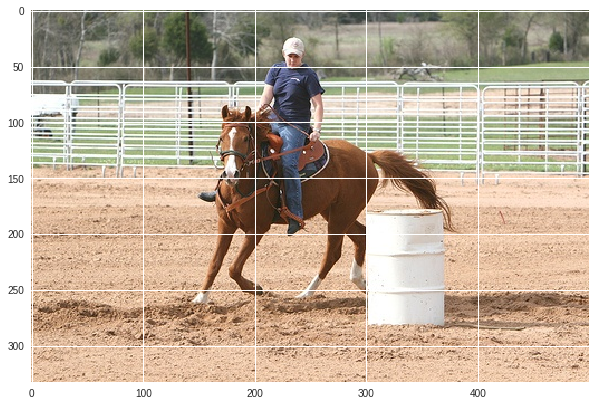

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'test')], None, VOCAnnotationTransform())
# クラスVOCDetectionはindexをキーに画像を取得する
img_id = 2586
image = testset.pull_image(img_id)

# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

In [0]:
# 画像のサイズを300×300に変更
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
#plt.imshow(x)
# HWCの形状[300, 300, 3]をCHWの形状[3, 300,300]に変更
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [0]:
# バッチサイズの次元を追加
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
# 順伝播を実行し、推論結果を出力    
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

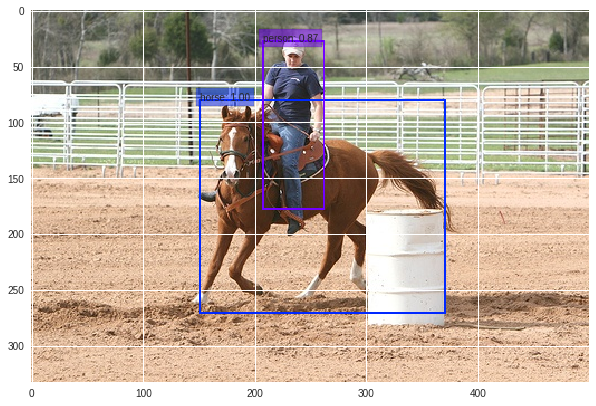

In [12]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# 推論結果をdetectionsに格納
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
# クラスiでループ
for i in range(detections.size(1)):
    j = 0
# 確信度confが0.6以上のボックスを表示
# jは確信度上位200件のボックスのインデックス
# detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [13]:
#(バッチサイズ、クラス番号、ランキング、確信度＋座標）
detections.shape

torch.Size([1, 21, 200, 5])

In [0]:
# 1次元目のクラス番号は以下のリストを参照　'aeroplane'は1番で、以降はカウントアップ
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

In [15]:
# horse[conf,xmin,ymin,xmax,ymax]
detections[0][13]

tensor([[0.9999, 0.3021, 0.2415, 0.7380, 0.8095],
        [0.1075, 0.3288, 0.2654, 0.4569, 0.4913],
        [0.0104, 0.3059, 0.2579, 0.4194, 0.5932],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [16]:
# person[conf,xmin,ymin,xmax,ymax]
detections[0][15]

tensor([[0.8674, 0.4151, 0.0816, 0.5228, 0.5302],
        [0.0310, 0.3220, 0.3915, 0.3858, 0.6066],
        [0.0287, 0.4304, 0.2937, 0.5016, 0.6015],
        [0.0241, 0.3812, 0.2329, 0.4466, 0.3943],
        [0.0239, 0.4137, 0.3136, 0.4771, 0.5572],
        [0.0232, 0.4104, 0.0694, 0.5364, 0.2669],
        [0.0229, 0.3349, 0.1895, 0.4498, 0.5778],
        [0.0203, 0.4103, 0.2149, 0.4572, 0.3912],
        [0.0169, 0.3332, 0.2432, 0.3964, 0.4078],
        [0.0126, 0.3581, 0.2508, 0.4107, 0.3070],
        [0.0125, 0.3867, 0.1234, 0.5181, 0.3641],
        [0.0124, 0.3812, 0.3510, 0.4485, 0.5509],
        [0.0119, 0.3460, 0.3856, 0.4132, 0.5674],
        [0.0113, 0.3274, 0.3378, 0.3910, 0.5187],
        [0.0111, 0.3760, 0.3256, 0.5197, 0.5521],
        [0.0109, 0.3518, 0.2265, 0.4193, 0.3675],
        [0.0105, 0.5981, 0.3854, 0.7443, 0.5572],
        [0.0101, 0.4028, 0.2578, 0.4438, 0.3027],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
